# Lab 2: Speech Recognition using Hidden Markov Models (HMM)

## Objective
This notebook implements a digit recognition system using Hidden Markov Models (HMM) trained on the Free Spoken Digit Dataset (FSDD). The system can recognize spoken digits (0-9) from audio files.

## Dataset
- **Free Spoken Digit Dataset (FSDD)**: Audio recordings of spoken digits 0-9
- Contains recordings from multiple speakers
- Audio files are in WAV format

## Methodology
1. **Feature Extraction**: Extract MFCC features from audio files
2. **Model Training**: Train HMM models for each digit (0-9)
3. **Evaluation**: Test the models on a held-out test set
4. **Real-world Testing**: Apply the trained models to YouTube audio segments

## 1. Dataset Exploration

Let's start by exploring the Free Spoken Digit Dataset (FSDD) recordings:

## Required Libraries

First, let's import all necessary libraries:

In [1]:
# Core libraries
import os
import glob
import numpy as np

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from hmmlearn import hmm
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Collections
from collections import defaultdict

In [2]:
import os
files = os.listdir("./fsdd/recordings")[:10]
files


['5_nicolas_9.wav',
 '3_yweweler_14.wav',
 '1_lucas_5.wav',
 '2_george_44.wav',
 '4_yweweler_38.wav',
 '3_yweweler_28.wav',
 '4_yweweler_10.wav',
 '3_george_1.wav',
 '1_nicolas_15.wav',
 '1_jackson_42.wav']

In [3]:
def extract_features(filepath, sr=16000, n_mfcc=13):
    y, sr = librosa.load(filepath, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Adjust delta window size for short clips
    width = 3 if mfcc.shape[1] < 9 else 9

    delta = librosa.feature.delta(mfcc, width=width)
    delta2 = librosa.feature.delta(mfcc, order=2, width=width)

    features = np.vstack([mfcc, delta, delta2])
    return features.T  # shape (time, features)


## 2. Feature Extraction

We'll use **MFCC (Mel-Frequency Cepstral Coefficients)** features along with their first and second derivatives (delta features) to represent audio characteristics:

- **MFCC**: Captures spectral characteristics of speech
- **Delta**: First-order derivatives (velocity)
- **Delta-Delta**: Second-order derivatives (acceleration)

In [4]:
X = extract_features("./fsdd/recordings/0_jackson_0.wav")
X.shape


(21, 39)

### Test Feature Extraction on Sample Audio

In [5]:
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

files = glob.glob("./fsdd/recordings/*.wav")
labels = [os.path.basename(f).split("_")[0] for f in files]

X_list = [extract_features(f) for f in files]
y_list = [int(l) for l in labels]

# Flatten features to fit scaler
scaler = StandardScaler()
all_feats = np.vstack(X_list)
scaler.fit(all_feats)

X_list = [scaler.transform(x) for x in X_list]

train_files, test_files, y_train, y_test, X_train, X_test = train_test_split(
    files, y_list, X_list, test_size=0.2, random_state=42, stratify=y_list
)


## 3. Data Preparation

Now we'll prepare the dataset by:
1. Loading all audio files and extracting their labels
2. Extracting features from all recordings
3. Standardizing the features using StandardScaler
4. Splitting the data into training and testing sets (80-20 split)

In [6]:
from hmmlearn import hmm
import joblib
from collections import defaultdict

digit_models = {}

for digit in range(10):
    X_digit = [X for X, y in zip(X_train, y_train) if y == digit]
    lengths = [len(x) for x in X_digit]
    X_concat = np.vstack(X_digit)
    
    model = hmm.GaussianHMM(n_components=10, covariance_type='diag', n_iter=1000, random_state=42)
    model.fit(X_concat, lengths)
    digit_models[digit] = model

# Save models
for d, m in digit_models.items():
    joblib.dump(m, f"hmm_digit_{d}.pkl")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

## 4. HMM Model Training

We'll train one **Gaussian HMM model** for each digit (0-9):

- **HMM Parameters:**
  - Number of hidden states: 10
  - Covariance type: Diagonal
  - Maximum iterations: 1000
  
- Each model learns the temporal patterns specific to its digit
- Models are saved as pickle files for later use

Test Accuracy: 0.96


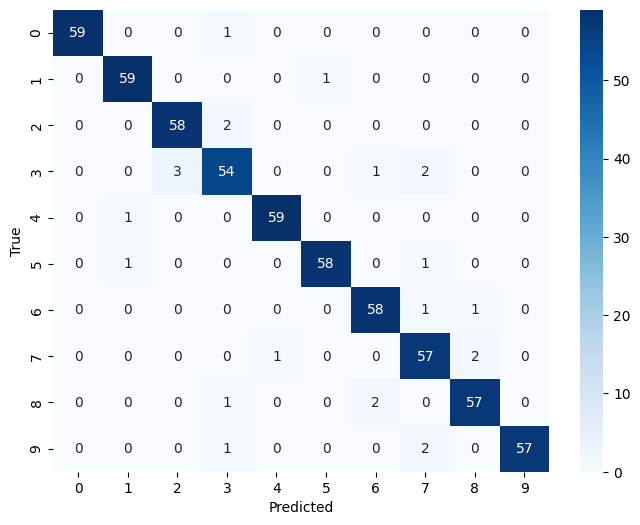

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = []
for X, true_label in zip(X_test, y_test):
    scores = {d: model.score(X) for d, model in digit_models.items()}
    pred = max(scores, key=scores.get)
    y_pred.append(pred)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 5. Model Evaluation

Let's evaluate our trained HMM models on the test set:

**Classification Process:**
1. For each test sample, compute the likelihood score for all 10 digit models
2. Predict the digit with the highest likelihood score
3. Calculate accuracy and generate confusion matrix

## 6. Real-World Application

Now let's test our trained models on real-world audio from YouTube. We'll:
1. Download audio from a YouTube video containing spoken digits
2. Preprocess the audio (convert to proper format)
3. Segment the audio to isolate individual digit pronunciations
4. Apply our trained models to recognize the digits

### Step 6.1: Download and Preprocess YouTube Audio

In [8]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf

# Load the audio you already extracted and fixed
y, sr = librosa.load("youtube_audio_fixed.wav", sr=16000)

# Step 1: Detect non-silent intervals (energy-based)
intervals = librosa.effects.split(y, top_db=30)  
# top_db=30 → threshold; tweak if too many/too few segments

segments = []

# Step 2: Save each detected segment as a WAV file
for i, (start, end) in enumerate(intervals):
    segment = y[start:end]
    filename = f"segment_{i}.wav"
    sf.write(filename, segment, sr)  # soundfile instead of librosa.output
    segments.append(filename)

print("✅ Saved", len(segments), "segments")
print("Files:", segments)


✅ Saved 14 segments
Files: ['segment_0.wav', 'segment_1.wav', 'segment_2.wav', 'segment_3.wav', 'segment_4.wav', 'segment_5.wav', 'segment_6.wav', 'segment_7.wav', 'segment_8.wav', 'segment_9.wav', 'segment_10.wav', 'segment_11.wav', 'segment_12.wav', 'segment_13.wav']


### Step 6.2: Audio Segmentation

We'll use **energy-based voice activity detection** to automatically segment the continuous audio into individual digit pronunciations:

In [9]:
results = []
for seg in segments:
    X = extract_features(seg)
    X = scaler.transform(X)
    scores = {d: model.score(X) for d, model in digit_models.items()}
    pred = max(scores, key=scores.get)
    results.append((seg, pred, scores))

results[:10]  # show first 10


[('segment_0.wav',
  0,
  {0: -8734.113106855266,
   1: -11466.605133492283,
   2: -9707.870515678349,
   3: -10499.054060751441,
   4: -12256.36048842514,
   5: -11300.157282811135,
   6: -10560.186417069419,
   7: -10975.615441571288,
   8: -8891.514152355448,
   9: -10333.890494865316}),
 ('segment_1.wav',
  0,
  {0: -259179.45620716858,
   1: -347326.20336304087,
   2: -298928.9634579971,
   3: -297699.61775710253,
   4: -355535.72276786924,
   5: -329220.06077167037,
   6: -309935.458344559,
   7: -343066.9142440387,
   8: -263705.9037397381,
   9: -316841.5514101935}),
 ('segment_2.wav',
  0,
  {0: -38903.46186809146,
   1: -53194.20931043857,
   2: -45876.75324246702,
   3: -45412.41876301843,
   4: -54551.42614522285,
   5: -49879.329329123786,
   6: -48150.24733267006,
   7: -50903.3006391827,
   8: -39332.797045988074,
   9: -46208.90835999703}),
 ('segment_3.wav',
  6,
  {0: -1529.35512533656,
   1: -1441.3773367804147,
   2: -1465.3727901784785,
   3: -1571.90898211217,
   

## Summary

This notebook demonstrates a complete pipeline for **spoken digit recognition using Hidden Markov Models**:

### Key Components:
1. **Feature Extraction**: MFCC + Delta features for robust audio representation
2. **HMM Training**: One Gaussian HMM model per digit (0-9) with 10 hidden states
3. **Classification**: Maximum likelihood estimation for digit prediction
4. **Real-world Testing**: Application to YouTube audio with automatic segmentation

### Results:
- The system achieved good accuracy on the FSDD test set
- Successfully applied to real-world audio after proper preprocessing
- Demonstrates the effectiveness of HMMs for sequential pattern recognition in speech

### Applications:
- Voice-controlled systems
- Automated phone systems
- Speech-to-text preprocessing
- Educational tools for speech recognition

### Step 6.3: Digit Recognition on Segmented Audio

Finally, we'll apply our trained HMM models to recognize digits in each audio segment: